In [21]:
from glob import glob
from tqdm import tqdm
from time import time
import argparse
import logging
import os
import cv2
import numpy as np
from PIL import Image
import base64
from matplotlib import pyplot as plt
import torch

from model import Unet
from dataset import load_image
from tensorrt_model import TrtModel

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(message)s')
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

def str2bool(v):
    if isinstance(v, bool):
        return v
    if v.lower() in ('true', '1'):
        return True
    elif v.lower() in ('false', '0'):
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')
        
def dice_loss(inputs, targets, smooth=1):
    inputs = inputs.reshape(-1)
    targets = targets.reshape(-1)

    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  

    return 1-dice 

def display_image(img, mask, local = False):
    img = img[0]
    mask = mask[0]
    
    img = np.transpose(img, (1,2,0))
    mask = np.transpose(mask, (1,2,0))
    
    img = img * 255
    img = np.minimum(np.maximum(img, 0), 255)
    mask[mask > 0.5] = 255
    mask[mask <= 0.5] = 0
    
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = img.astype(np.int16)
    green = np.zeros_like(mask)
    green[:,:,1] = mask[:,:,1]
    img[green >= 255] = img[green >= 255] * 3
    img[img >= 255] = 255

    other = np.zeros_like(mask)
    other[:,:,[0,2]] = mask[:,:,[0,2]] 
    img[other >= 255] = img[other >= 255] * 0.3
    
    plt.imshow(img)
    # cv2.imshow('img', img)
    # cv2.waitKey(1)

In [19]:
def inference(model_path, data_path, display = False):
    logger.info('model loading.. {}'.format(model_path))
    batch_size = 1
     # os.path.join("..","models","main.trt")
    model = TrtModel(model_path)
    shape = model.engine.get_binding_shape(0)
    
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = Unet().to(device)
    # model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
    # model = model.eval()
    
    # data_paths = glob(dataset_path)
    
    
    logger.info('dataset loading..')
   
    with open(data_path, 'r') as f:
        line = f.readlines()

    total = len(line)
    logger.info('number of test dataset : {}'.format(total))
    
    logger.info('start inferencing')
    preds = []
    targets = []
    cnt = 0
    
    base_dir = os.path.dirname(data_path)
    imgs = []
    masks = []
    filepaths = []
    
#     for row in tqdm(line):
#         img_path, mask_path = row.rstrip().split(',')
        
#         img = load_image(os.path.join(base_dir, img_path))
#         mask = load_image(os.path.join(base_dir, mask_path))
#         img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
#         mask = mask.reshape(1, mask.shape[0], mask.shape[1], mask.shape[2])
        
#         imgs.append(img)
#         masks.append(mask)
#         filepaths.append(os.path.basename(img_path))
    
    start_time = time()
    pre_elap = 0.0
    fps = 0.0
    cost = .0
    loss = .0
    for idx, row in enumerate(line):
        filename, _ = row.rstrip().split(',')
        filename = os.path.basename(filename)
        
        img = load_image(os.path.join(base_dir, 'images', filename))
        mask = load_image(os.path.join(base_dir, 'masks', filename))
        img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        mask = mask.reshape(1, mask.shape[0], mask.shape[1], mask.shape[2])
        
        # img = load_image(os.path.join(base_dir,'images',filename))
        # img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
        
        # img = torch.tensor(img).to(device).type(torch.float32)
        # mask = torch.tensor(mask).to(device).type(torch.float32)
        
        # print(img)
        
        output = model(img)
        output = output[0].reshape(mask.shape)
        
        loss = dice_loss(output, mask)
        
        cost += loss
        
        print('{}/{} - {},  fps: {:.1f}, dice loss: {:.1f}'.format(idx+1, total, filename, fps, (loss)))

        # if(display):
        display_image(img, mask)
        
        elap = time() - start_time
        fps = max(0.0, 1.0 / (elap - pre_elap))
        pre_elap = elap
        break
        
        
    if(display):
        cv2.destroyAllWindows()

    # preds = torch.tensor(preds)
    # targets = torch.tensor(targets)
    # # acc = (correct/len(dataset))
    # f1_score = f1(preds, targets) 
    
    elap = time() - start_time
    fps = total / elap
    logger.info('dice coefficient: {:.4f}, fps: {:.4f}'.format(cost/total, fps))

2022-10-04 08:17:22,583 - model loading.. /home/workspace/iot_ai_model/check_points/unet/model.engine
2022-10-04 08:17:22,583 - model loading.. /home/workspace/iot_ai_model/check_points/unet/model.engine
2022-10-04 08:17:22,583 - model loading.. /home/workspace/iot_ai_model/check_points/unet/model.engine
2022-10-04 08:17:22,583 - model loading.. /home/workspace/iot_ai_model/check_points/unet/model.engine
2022-10-04 08:17:22,618 - dataset loading..
2022-10-04 08:17:22,618 - dataset loading..
2022-10-04 08:17:22,618 - dataset loading..
2022-10-04 08:17:22,618 - dataset loading..
2022-10-04 08:17:22,625 - number of test dataset : 534
2022-10-04 08:17:22,625 - number of test dataset : 534
2022-10-04 08:17:22,625 - number of test dataset : 534
2022-10-04 08:17:22,625 - number of test dataset : 534
2022-10-04 08:17:22,630 - start inferencing
2022-10-04 08:17:22,630 - start inferencing
2022-10-04 08:17:22,630 - start inferencing
2022-10-04 08:17:22,630 - start inferencing
2022-10-04 08:17:22,

load /home/workspace/iot_ai_model/check_points/unet/model.engine
1/534 - ds5_pexels-photo-245241.png,  fps: 0.0, dice loss: 0.9


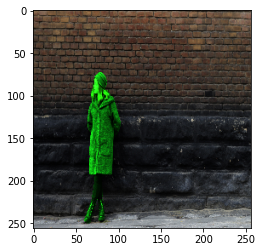

In [20]:
inference('/home/workspace/iot_ai_model/check_points/unet/model.engine', '/home/workspace/iot_ai_model/dataset/supervisely_person/test_data_list.txt')

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Unet().to(device)
model.load_state_dict(torch.load('/home/workspace/iot_ai_model/check_points/unet/model_state_dict_latest.pt'))
model = model.eval()

In [ ]:
model = TrtModel(model_path)
shape = model.engine.get_binding_shape(0)